In [1]:
import app.importer as importer
from app.data import get_data_csv

import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

import io

sns.set_style('darkgrid')
pd.set_option('display.max_rows', 100)

# Import data to our local sqlite database

In [3]:
# This only needs to be done once
importer.import_data()

Louvre in Paris France, population 9904000, with 10200000 visitors per year
National Museum of China in Beijing China, population 11106000, with 8610092 visitors per year
Metropolitan Museum of Art[a] in New York City United States, population 8175133, with 6953927 visitors per year
Vatican Museums in Vatican City Vatican City, population 825, with 6756186 visitors per year
National Air and Space Museum in Washington, D.C. United States, population 702455, with 6200000 visitors per year
Tate Modern in London United Kingdom, population 8567000, with 5868562 visitors per year
British Museum in London United Kingdom, population 8567000, with 5829000 visitors per year
National Gallery in London United Kingdom, population 8567000, with 5735831 visitors per year
Natural History Museum in London United Kingdom, population 8567000, with 5226000 visitors per year
American Museum of Natural History in New York City United States, population 8175133, with 5000000 visitors per year
National Museum

In [2]:
# Run if you want to clean up, importing data is blocked if its already been imported
# importer.delete_data()

# Load our dataframe

In [4]:
output = io.StringIO()
museums_data = get_data_csv()
output.write(museums_data)
output.seek(0)
museums_df = pd.read_csv(output)
museums_df.set_index('museum_name', inplace=True)

# Add some calculated columns that will be convenient later
museums_df['visitors_per_population'] = museums_df.apply(lambda row: row.visitors_per_year / row.population, axis=1)
asian_countries = ["Japan", "Shanghai", "China", "Seoul", "South Korea"]
museums_df['is_asian_country'] = museums_df.apply(lambda row: row.country_name in asian_countries, axis=1)

In [5]:
museums_df

,visitors_per_year,city_name,country_name,population,visitors_per_population,is_asian_country
museum_name,,,,,,
Louvre,10200000,Paris,France,9904000,1.029887,False
National Museum of China,8610092,Beijing,China,11106000,0.775265,True
Metropolitan Museum of Art[a],6953927,New York City,United States,8175133,0.850619,False
Vatican Museums,6756186,Vatican City,Vatican City,825,8189.316364,False
National Air and Space Museum,6200000,"Washington, D.C.",United States,702455,8.826188,False
Tate Modern,5868562,London,United Kingdom,8567000,0.685019,False
British Museum,5829000,London,United Kingdom,8567000,0.680402,False
National Gallery,5735831,London,United Kingdom,8567000,0.669526,False
Natural History Museum,5226000,London,United Kingdom,8567000,0.610015,False


# Do some data exploration!

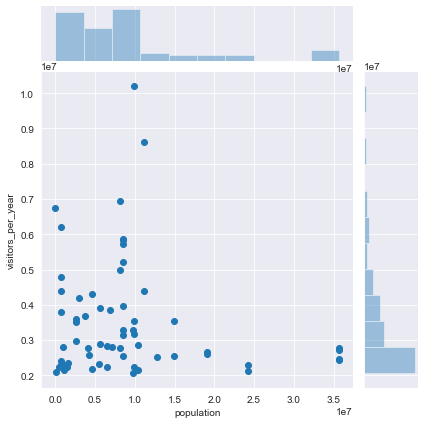

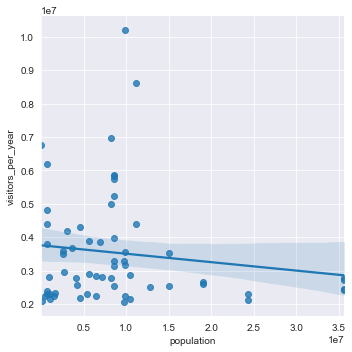

In [6]:
sns.jointplot(data=museums_df,x='population', y='visitors_per_year')
sns.lmplot(data=museums_df, x='population', y='visitors_per_year')

### How strange! It appears that museum vits are inversely correlated with population! Barely, it's almost uncorrelated, but still, the negative trend is unexpected! This warrants further exploration

In [7]:
x_axis = museums_df['population']
y_axis = museums_df['visitors_per_year']
linear_reg = LinearRegression()
linear_reg.fit(x_axis.values.reshape(-1, 1), y_axis.values.reshape(-1, 1))
linear_reg.coef_[0][0]

-0.025230710296463635

### Let's find some outliers in the Visitors / Population ratio

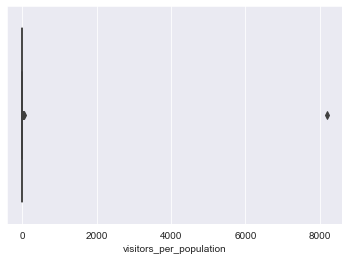

In [16]:
sns.boxplot(museums_df['visitors_per_population'])

### Yikes! What's going on here? There's a tiny town with a super popular museum! 
oh. its the Vatican. That's cheating. We should probably use Rome's population

In [17]:
museums_df_fixed_vatican = museums_df.copy()
museums_df_fixed_vatican.at['Vatican Museums', 'population'] = 2860009
museums_df_fixed_vatican.at['Vatican Museums', 'visitors_per_population'] = museums_df_fixed_vatican.at['Vatican Museums', 'visitors_per_year'] / museums_df_fixed_vatican.at['Vatican Museums', 'population']

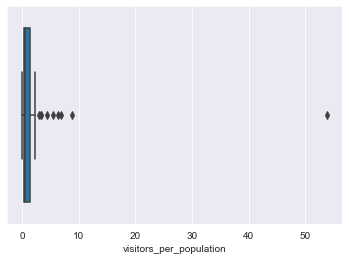

In [18]:
sns.boxplot(museums_df_fixed_vatican['visitors_per_population'])

### We still have one major outlier, Auschwitz, a museum that's not located within a major city, for obvious reasons. Let's redo our linear regression.

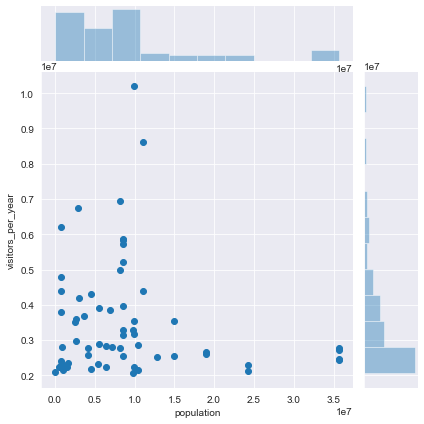

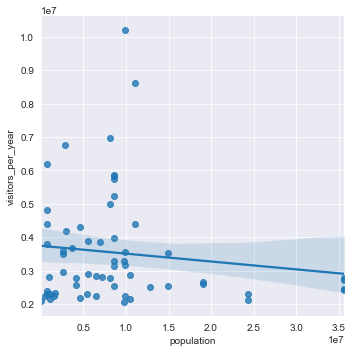

In [19]:
sns.jointplot(data=museums_df_fixed_vatican,x='population', y='visitors_per_year')
sns.lmplot(data=museums_df_fixed_vatican, x='population', y='visitors_per_year')

In [20]:
x_axis_without_vatican = museums_df_fixed_vatican['population']
y_axis_without_vatican = museums_df_fixed_vatican['visitors_per_year']
linear_reg_without_vatican = LinearRegression()
linear_reg_without_vatican.fit(x_axis_without_vatican.values.reshape(-1, 1), y_axis_without_vatican.values.reshape(-1, 1))
linear_reg_without_vatican.coef_[0][0]

-0.023556766106745806

### The ratio is a little less negative, but it still shows a negligeable level of correlation
### Out of curiosity, lets see how it is without Auschwitz

In [24]:
museums_df_without_auschwitz = museums_df_fixed_vatican.copy()
museums_df_without_auschwitz.drop('Auschwitz-Birkenau State Museum', inplace=True)

x_axis_without_auschwitz = museums_df_without_auschwitz['population']
y_axis_without_auschwitz = museums_df_without_auschwitz['visitors_per_year']
linear_reg_without_auschwitz = LinearRegression()
linear_reg_without_auschwitz.fit(x_axis_without_auschwitz.values.reshape(-1, 1), y_axis_without_auschwitz.values.reshape(-1, 1))
linear_reg_without_auschwitz.coef_[0][0]

-0.02668025496025463

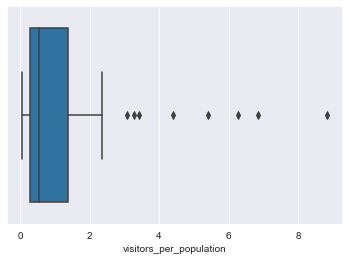

In [25]:
sns.boxplot(museums_df_without_auschwitz['visitors_per_population'])

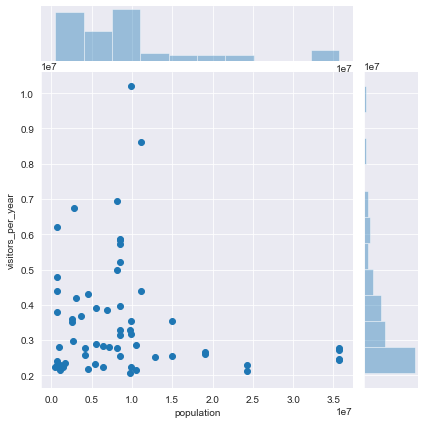

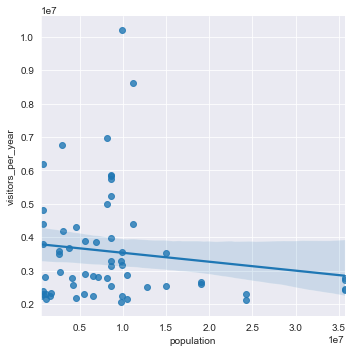

In [26]:
sns.jointplot(data=museums_df_without_auschwitz,x='population', y='visitors_per_year')
sns.lmplot(data=museums_df_without_auschwitz, x='population', y='visitors_per_year')

# The visitors / population ratio
Looking at our dataset, the visitors / population ratio varies a lot. Can we spot some patterns?


In [27]:
museums_df.sort_values(by=['visitors_per_population'])

,visitors_per_year,city_name,country_name,population,visitors_per_population,is_asian_country
museum_name,,,,,,
Tokyo National Museum,2431073,Tokyo,Japan,35676000,0.068143,True
National Museum of Nature and Science,2460000,Tokyo,Japan,35676000,0.068954,True
National Art Center,2717565,Tokyo,Japan,35676000,0.076173,True
Tokyo Metropolitan Art Museum,2787770,Tokyo,Japan,35676000,0.078141,True
Shanghai Museum,2111730,Shanghai,Shanghai,24281400,0.086969,True
China Art Museum,2300000,Shanghai,Shanghai,24281400,0.094723,True
National Museum of Anthropology,2596725,Mexico City,Mexico,19028000,0.136469,False
National Museum of History,2661615,Mexico City,Mexico,19028000,0.139879,False
China Art Museum,2550000,Shanghai,China,14987000,0.170147,True


## The cities with the lowest visitor to population ratio seem to be asian megacities, where the level of tourism compared to the local population size is probably much lower than western cities. Let's split our dataset in two.

In [29]:
asian_museums_df = museums_df[museums_df['is_asian_country']]
non_asian_museums_df = museums_df[museums_df['is_asian_country'] == False]

### Asian museums

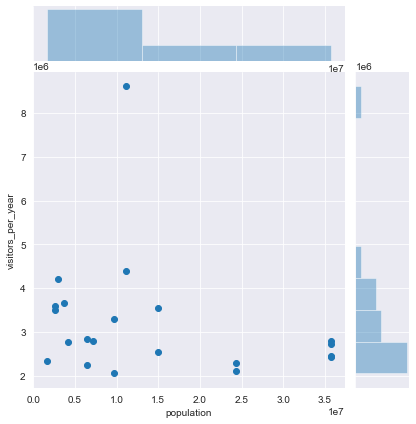

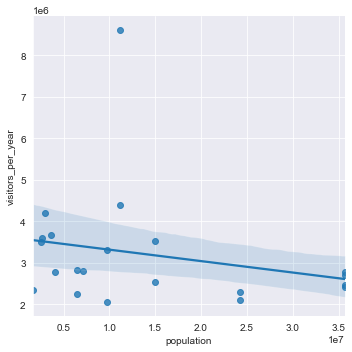

In [30]:
sns.jointplot(data=asian_museums_df,x='population', y='visitors_per_year')
sns.lmplot(data=asian_museums_df, x='population', y='visitors_per_year')

In [31]:
x_axis_asian = asian_museums_df['population']
y_axis_asian = asian_museums_df['visitors_per_year']
linear_reg_asian = LinearRegression()
linear_reg_asian.fit(x_axis_asian.values.reshape(-1, 1), y_axis_asian.values.reshape(-1, 1))
linear_reg_asian.coef_[0][0]

-0.027546048039224547

### Non-Asian museums

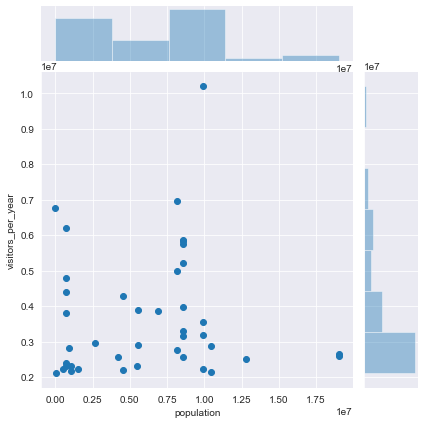

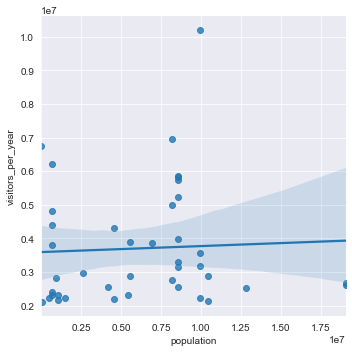

In [32]:
sns.jointplot(data=non_asian_museums_df,x='population', y='visitors_per_year')
sns.lmplot(data=non_asian_museums_df, x='population', y='visitors_per_year')

In [33]:
x_axis_non_asian = non_asian_museums_df['population']
y_axis_non_asian = non_asian_museums_df['visitors_per_year']
linear_reg_non_asian = LinearRegression()
linear_reg_non_asian.fit(x_axis_non_asian.values.reshape(-1, 1), y_axis_non_asian.values.reshape(-1, 1))
linear_reg_non_asian.coef_[0][0]

0.017851689937082367

### A positive correlation! Barely!

# Analysis

In conclusion, for the reasons we discovered above, it would appear that museums visits and city populations are completely unrelated.

A more meaningful study would be correlating museum visits to out-of-town tourists, rather than local population. While there is certainly some correlation between local and tourist populations, due to large cities drawing in more tourists, it would probably still provide a much better correlation by cleaning up the large-but-rarely-visited cities.

But there is clearly more than just population or number of tourists that affects museum visits. We only have to look at cities with multiple museums. Paris, for instance, has 4 museums, with the most popular drawing 10.2M visits while the 4th only has 2.23M visits. And that's only considering the museums with over 2M visits. Clearly something else affects which museums get visited.

It could also be interesting to see how museum visits scale with the number of museums within the same city. Do more museums create a critical mass that turns a city into a "museum capital", drawing in larger crowds than if there was just one main museum? Or on the contrary, do they cannibalize each other's visits because people are in town for other reasons and just want to check a single museum to fill their bucket list?